In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib  import cm
import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF

THRESHOLD = 0.5
W1 = 1
W2 = 20
W3 = 100
W4 = 0.01


def cost_function(true, predicted):
    """
        true: true values in 1D numpy array
        predicted: predicted values in 1D numpy array
        return: float
    """
    cost = (true - predicted) ** 2

    # true above threshold (case 1)
    mask = true > THRESHOLD
    mask_w1 = np.logical_and(predicted > true, mask)
    mask_w2 = np.logical_and(np.logical_and(predicted < true, predicted > THRESHOLD), mask)
    mask_w3 = np.logical_and(predicted < THRESHOLD, mask)

    cost[mask_w1] = cost[mask_w1] * W1
    cost[mask_w2] = cost[mask_w2] * W2
    cost[mask_w3] = cost[mask_w3] * W3

    # true value below threshold (case 2)
    mask = true <= THRESHOLD
    mask_w1 = np.logical_and(predicted > true, mask)
    mask_w2 = np.logical_and(predicted < true, mask)

    cost[mask_w1] = cost[mask_w1] * W1
    cost[mask_w2] = cost[mask_w2] * W2

    # reward for correctly identified safe regions
    reward = W4 * np.logical_and(predicted <= THRESHOLD, true <= THRESHOLD)

    return np.mean(cost) - np.mean(reward)


In [2]:
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')

In [3]:
df_vals = np.stack([train_x[:,0],train_x[:,1],train_y],axis=1)
print(df_vals)
print(df_vals.shape)

[[-1.         -1.          0.75400097]
 [-1.         -0.98657718  0.83958557]
 [-1.         -0.97315436  0.81706415]
 ...
 [-0.47651007 -0.73154362  0.22523587]
 [ 0.5033557   0.53020134  0.49737222]
 [ 0.00671141  0.5033557   0.29129925]]
(17250, 3)


In [4]:
#print(train_x)
print(np.shape(train_x))

#print(train_y)
print(np.shape(train_y))

#print(test_x)
print(np.shape(test_x))

(17250, 2)
(17250,)
(100, 2)


In [ ]:
plt.hist(train_x[:,0],bins=50)

In [ ]:
plt.hist(train_x[:,1],bins=50)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
points = ax.scatter(train_x[:,0],train_x[:,1],s=1,c=train_y, marker = 'o', cmap = cm.jet );
fig.colorbar(points)

plt.show()

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
points = ax.scatter(test_x[:,0],test_x[:,1])
#fig.colorbar(points)

plt.show()

In [18]:
df = pd.DataFrame(data = df_vals,columns = ['x0','x1','y'])
print(df.shape)

### Modifiable
df_left = df[df['x0']<-0.5]
#df_left = df_left[df_left['x0']>-0.54]
df_left = df_left.sample(frac=0.1,random_state=42)

df_right = df[df['x0']>-0.5]
###



print(df_left.shape)
print(df_right.shape)

(17250, 3)
(1710, 3)
(150, 3)


In [19]:

#cross validation
K_cv = 10

df_right = df_right.sample(frac=1,random_state=42)
df_right_splits = np.array_split(df_right,K_cv)

#print(type(df_right_splits[0]))
#print(df_right_splits[0].shape)



val_cost_array = np.array([])
models = []
for i in range(0,K_cv):
    print("i=%d"%i)
    df_train_list = [df_left]
    for j in range(0,K_cv):
        if j!=i:
            df_train_list.append(df_right_splits[j])
    #print(len(df_train_list))
    df_train = pd.concat(df_train_list)
    df_val = df_right_splits[i]
    
    X_train = df_train[['x0','x1']].values
    y_train = df_train['y'].values
    X_val = df_val[['x0','x1']].values
    y_val = df_val['y'].values
    
    kernel = RBF(length_scale=1.0)+WhiteKernel(noise_level=0.5)
    gpr = GaussianProcessRegressor(kernel=kernel,copy_X_train=False,random_state=42).fit(X_train, y_train)
    
    #y_test_pred = gpr.predict(X_test)
    #print(y_test_pred)
    
    models.append(gpr)
    
    #print("train and val shapes %s %s %s %s"%(str(np.shape(X_train)),
    #                                          str(np.shape(y_train)),
    #                                          str(np.shape(X_val)),
    #                                          str(np.shape(y_val))))
    
    


    print("training gpr score %f"%(gpr.score(X_train,y_train)))

    y_train_pred = gpr.predict(X_train)
    #print(np.shape(y_train_pred))
    print("training cost fn   %f"%(cost_function(y_train,y_train_pred)))

    y_val_pred = gpr.predict(X_val)
    print(y_val_pred)
    #print(np.shape(y_val_pred))
    val_cost = cost_function(y_val,y_val_pred)
    print("val cost fn        %f"%(val_cost))
    val_cost_array = np.append(val_cost_array,val_cost)
    print("\n")

print(np.mean(val_cost_array))
print(np.std(val_cost_array))

i=0
[0.15739953 0.21811722 0.57939193 0.14859659 0.11164392 0.39727227
 0.58558016 0.29487723 0.39099594 0.40581926 0.1894921  0.11451638
 0.19484443 0.09348009 0.40950682 0.1699264  0.55286299 0.50430253
 0.13303555 0.20407619 0.07411774 0.42301367 0.081254   0.40827517
 0.82973901 0.06240012 0.53459547 0.63879063 0.4909384  0.43141115
 0.76166975 0.12273806 0.54001767 0.07845119 0.11883983 0.10556622
 0.32532393 0.16083484 0.77094192 0.20257586 0.36827059 0.09937626
 0.09719758 0.65113035 0.09408817 0.33595904 0.44873024 0.75088597
 0.73815349 0.11264501 0.40600421 0.06181302 0.78088118 0.41865252
 0.10158624 0.3921142  0.20074161 0.12391312 0.59296916 0.39792632
 0.35135943 0.11641021 0.74346017 0.36219281 0.21697351 0.52907516
 0.41190572 0.26390623 0.12272385 0.32764487 0.2136041  0.30106549
 0.17805714 0.25252581 0.02098347 0.45136057 0.39860809 0.5459545
 0.47657017 0.2396761  0.39668326 0.42640608 0.01538135 0.62123705
 0.24843945 0.39062044 0.53870171 0.23976191 0.41897428 0.6

[0.15289087 0.21193184 0.56025893 0.18362794 0.13479531 0.37988666
 0.58061305 0.27109075 0.37422996 0.44100922 0.17969278 0.09824986
 0.22632976 0.12385304 0.41596825 0.20659176 0.57061869 0.54661987
 0.00996729 0.218962   0.09501574 0.45105629 0.09407157 0.40383838
 0.81591058 0.0550349  0.53890205 0.64778472 0.50121203 0.42619934
 0.76180617 0.12159429 0.54226717 0.07641281 0.0456077  0.13009307
 0.32072071 0.15704241 0.78935231 0.20447755 0.35438437 0.09657363
 0.10370189 0.85556456 0.10859383 0.32848263 0.39434673 0.66669516
 0.75617428 0.11369494 0.41840347 0.07697602 0.67777833 0.41845692
 0.12557995 0.39515779 0.18767129 0.12097827 0.57469505 0.39828414
 0.38529505 0.11507076 0.67685826 0.29645744 0.21816528 0.52393207
 0.41968149 0.28375816 0.13517414 0.32665    0.24594626 0.32523297
 0.19274922 0.25569092 0.01766136 0.52981638 0.39100226 0.53985198
 0.5037519  0.24230989 0.39685847 0.33619556 0.02158929 0.63123039
 0.26892868 0.39336722 0.58975885 0.23078345 0.42769751 0.7943

In [21]:
print("train and val shapes %s %s %s %s"%(str(np.shape(X_train)),
                                          str(np.shape(y_train)),
                                          str(np.shape(X_val)),
                                          str(np.shape(y_val))))
print(np.shape(y_train_pred))
print(np.shape(y_val_pred))

train and val shapes (1845, 2) (1845,) (15, 2) (15,)
(1845,)
(15,)


In [ ]:
print(models)

(1860, 3)


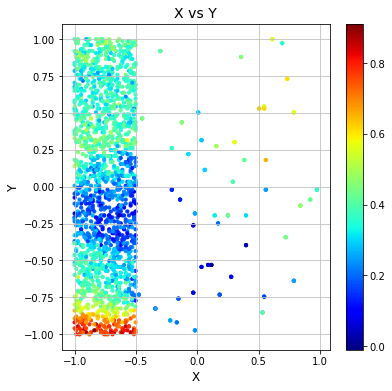

In [22]:
df_left_right = pd.concat([df_left,df_right])
print(df_left_right.shape)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
points = ax.scatter(df_left_right['x0'].values,
                    df_left_right['x1'].values,
                    s=10,
                    c=df_left_right['y'].values, 
                    marker = 'o', cmap = cm.jet );
fig.colorbar(points)
plt.show()

In [ ]:
X_test = test_x


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("X vs Y",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
points = ax.scatter(X_test[:,0],
                    X_test[:,1],
                    s=10,
                    c=y_test, 
                    marker = 'o', cmap = cm.jet );
fig.colorbar(points)
plt.show()